In [708]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from itertools import product
from scipy import stats

In [219]:
def sum_of_squares(samples: np.ndarray) -> float:
    return ((samples - samples.mean()) ** 2).sum()

1. Дана матрица объект-признак и значения целевой переменной. Необходимо:

 - подобрать два признака из четырёх так, чтобы модель линейной регрессии на этих признаках давала наилучший результат,
 - определить, является ли значимым получившееся уравнение регрессии.

In [249]:
X = np.array([[ 1.22401313, 2.30868478, 3.03636353, 2.69287214],
[-0.18757272, 1.30337355, 5.12093014, 3.46363202],
[-0.81094525, 1.82463398, 5.79686488, 1.86159445],
[ 0.75129018, 2.67392052, 3.65529809, 1.66746094],
[ 0.00972362, 1.97367255, 2.50594319, 1.69755173],
[-0.62972637, 0.77750764, 2.84124027, 4.54410559],
[ 2.29536229, 1.81206697, 1.95026215, 1.51874636],
[ 0.0920418 , 2.26971361, 7.47708735, 2.61081203],
[ 2.39252799, 3.17563985, 3.61420599, 5.10773362],
[ 0.54983815, 2.87988651, 1.65752765, 1.59635987]])

In [250]:
y = np.array([ 9.26193358, 9.700363 , 8.67214805, 8.74796974, 6.18689108,
7.53312713, 7.57643777, 12.44965478, 14.29010746, 6.68361218])

__Подбор признаков__

In [259]:
mask = list(product(range(4), repeat=2))
mask = list(set(tuple(sorted([m, n])) for m, n in mask if m!=n))
mask

[(0, 1), (1, 2), (1, 3), (2, 3), (0, 3), (0, 2)]

In [252]:
pairs = list((X[:,m],X[:,n]) for m, n in mask)

In [576]:
ones = np.ones((X.shape[0], 1))
matrix_det = []
coef_list = []
corr_list = []

for group in pairs:
    # преобразуем пару в признаки
    
    pair = np.array(group).T 
    
    #добавляем к паре единичный столбец, чтобы в последствии подсчитать
    #свободную константу линейной регресии
    
    pair = np.hstack((ones, pair))
    
    # для пары вычисляем коэффициенты линейной регрессии (b)
    # для проверки считаем определитель матрицы (det). Близок ли он к 0 или нет.
    
    XTX = pair.T.dot(pair)
    det = np.linalg.det(XTX)
    XTX_inv = np.linalg.inv(XTX)
    b = XTX_inv.dot(pair.T).dot(y)
    
    # строим предсказание
    
    y_pred = pair.dot(b)
    
    # вычисляем ошибку (факт - предсказание)
    # дополнительно - коэффициент корелляции Пирсона^2 (факт - предсказание)
    
    e = y - y_pred
    corr = np.corrcoef(y,y_pred)[0,1]**2
    
    # вычисляем коэффициент детерминации для оценки качества линейной регрессии
    
    R = 1 - sum_of_squares(e) / sum_of_squares(y)
    
    # сохраняем все основные показатели в списки для каждой из пар признаков
    
    matrix_det.append(det)
    corr_list.append(corr)
    coef_list.append(R)

# создаем результирующую таблицу всех пар и названия к ним.

table = list(zip(matrix_det,coef_list,corr_list))
pair_name = [str(i) for i in mask]

In [577]:
result = pd.DataFrame(table,columns = ('matrix_det','R2', 'Pearson^2'), index = pair_name)
result

,matrix_det,R2,Pearson^2
"(0, 1)",349.778203,0.181136,0.181136
"(1, 2)",1427.812578,0.547948,0.547948
"(1, 3)",701.732736,0.606206,0.606206
"(2, 3)",4547.328075,0.622442,0.622442
"(0, 3)",1689.212474,0.453297,0.453297
"(0, 2)",2835.360023,0.763425,0.763425


Пара из 1-го и 3-го признаков дает наилучший результат для линейной регрессии. Помним, что нумерация начинается с 0 :)

__Проверка max_R2 на значимость: тест Фишера.__

In [504]:
n = X.shape[0]
m = 2

k1 = m
k2 = n - m - 1

k1, k2

(2, 7)

In [505]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
F = (coef_list[-1] / k1) / ((1 - coef_list[-1]) / k2)
F,t

(11.29443912292265, 4.73741412777588)

Значение статистики попадает в критическую зону, то есть нулевая гипотеза отвергается и уравнение линейной регресии признается значимым.

2. Для проведения A/B-тестирования сайта интернет-магазина были получены следующие данные: страница A была посещена 2509 раз, из них 77 закончились совершением покупки, страница B была посещена 1465 раз, 60 из них закончились совершением покупки. Является ли значимым отличие конверсии на страницах A и B?

In [490]:
alpha = 0.05
k = 2
orders = [77, 60]
visits = [2509, 1465]

По сути конверсия - это среднее значение. Таким образом, можно посчитать среднее значение как по двум выборкам (A+B), так и по каждой выборке (A или В)

In [493]:
n = sum(visits)
total_conv = sum(orders)/sum(visits)
conversions = list(map(lambda x,y: x / y, orders, visits))
conversions, total_conv

([0.03068951773614986, 0.040955631399317405], 0.03447408152994464)

Посчитаем отклонение среднего (конверсии) по каждой группе от общего среднего (то есть от общей конверсии).

In [494]:
SS_b = sum(map(lambda x,y: y * (x - total_conv)**2, conversions, visits))
SS_b

0.09748158004016791

На первой странице 77 пользователей совершили покупку, то есть  целевое значение = 1. (2509-77) пользователей не совершили покупку, то есть целевое значение = 0. Теперь посчитаем отклонение по каждому результату от среднего внутри группы с учетом количества совершивших покупку и не совершивших ее и просуммируем результаты сначала внутри каждой из группу, а после - между группами.

In [480]:
SS_w = sum(map(lambda x,y,z: (y - z) * (0 - x)**2 + z * (1 - x)**2, conversions, visits, orders))
SS_w

132.17956925035742

In [495]:
k1 = k - 1
k2 = n - k

sigma2_b = SS_b / k1
sigma2_w = SS_w / k2


F = sigma2_b / sigma2_w
t = stats.f.ppf(1 - alpha, k1, k2)
F , t, F > t

(2.92932438890135, 3.8438010503414866, False)

Статистика НЕ попадает в критическу зону, то есть подтверждается нулевая гипотеза о том, что нет значимых различий между страницами А и В.

3. Квартет Энскомба — популярный в области анализа данных пример наборов данных, у которых практически совпадают все статистические свойства (средние, дисперсии, коэффициенты корреляции, регрессионные линии), однако, существенно отличаются графики. Данный пример призван показать, насколько важна визуализация данных. По каждой паре выборок:

 - посчитаем выборочное среднее и дисперсию,
 - посчитаем коэффициент корреляции Пирсона и прямую линейной регрессии.
 - построим scatter plot.

In [507]:
Anscombe_Quartet = {
    "x1": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y1": [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68],
    "x2": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y2": [9.14, 8.14, 8.74, 8.77, 9.26, 8.1, 6.13, 3.1, 9.13, 7.26, 4.74],
    "x3": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
    "y3": [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73],
    "x4": [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 19.0, 8.0, 8.0, 8.0],
    "y4": [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.5, 5.56, 7.91, 6.89]
}

In [658]:
df = pd.DataFrame(Anscombe_Quartet)
df

,x1,y1,x2,y2,x3,y3,x4,y4
0,10.0,8.04,10.0,9.14,10.0,7.46,8.0,6.58
1,8.0,6.95,8.0,8.14,8.0,6.77,8.0,5.76
2,13.0,7.58,13.0,8.74,13.0,12.74,8.0,7.71
3,9.0,8.81,9.0,8.77,9.0,7.11,8.0,8.84
4,11.0,8.33,11.0,9.26,11.0,7.81,8.0,8.47
5,14.0,9.96,14.0,8.10,14.0,8.84,8.0,7.04
6,6.0,7.24,6.0,6.13,6.0,6.08,8.0,5.25
7,4.0,4.26,4.0,3.10,4.0,5.39,19.0,12.50
8,12.0,10.84,12.0,9.13,12.0,8.15,8.0,5.56
9,7.0,4.82,7.0,7.26,7.0,6.42,8.0,7.91


__Среднее:__

In [699]:
mean = np.array(df.mean())
mean

array([9.        , 7.50090909, 9.        , 7.50090909, 9.        ,
       7.5       , 9.        , 7.50090909])

__Дисперсия:__

In [692]:
variation = np.array(df.var())
variation

array([11.        ,  4.12726909, 11.        ,  4.12762909, 11.        ,
        4.12262   , 11.        ,  4.12324909])

__Коэффициент корреляции Пирсона:__

In [696]:
pearson = np.array([df[[f'x{i}', f'y{i}']].corr().iloc[0,1] for i in range(1,5)])
pearson

array([0.81642052, 0.81623651, 0.81628674, 0.81652144])

__Коэффициенты для парной регрессии b0, b1:__

In [707]:
covariation = np.array([df[f'x{i}'].cov(df[f'y{i}']) for i in range(1,5)])
b1 = covariation/variation[0]
b0 = mean[1] - b1*mean[0]
coef = list(zip(b1,b0))
coef

[(0.5000909090909093, 3.0000909090909094),
 (0.5000000000000001, 3.000909090909092),
 (0.49972727272727285, 3.0033636363636367),
 (0.49990909090909086, 3.0017272727272752)]

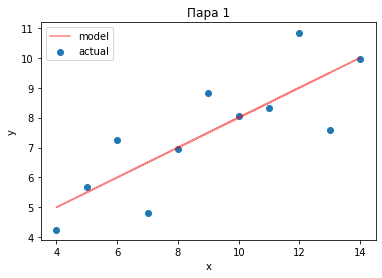

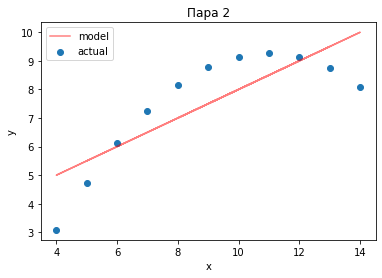

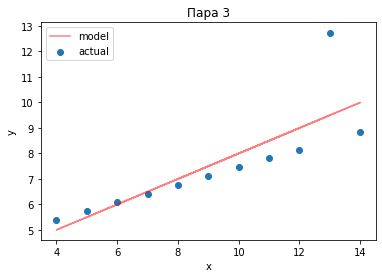

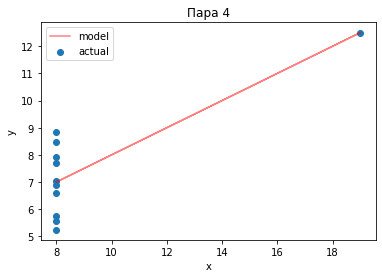

In [740]:
i = 0

for n in range(1,5):
    ox = df[f'x{n}']
    oy = b0[i] + b1[i] * ox
    
    plt.scatter(df[f'x{n}'], df[f'y{n}'], label='actual' )
    plt.plot(ox, oy, color='red', label='model', alpha=0.5)
    
    plt.title(f'Пара {n}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
    plt.show()
    
    i+=1